<a href="https://colab.research.google.com/github/sungj0/data-ai/blob/master/lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()
path

PosixPath('/root/.fastai/data/camvid')

In [5]:
path_lbl = path/'labels'
path_img = path/'images'
path_lbl

PosixPath('/root/.fastai/data/camvid/labels')

## Subset classes

In [6]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]
len(fnames)

701

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]
len(lbl_names)

701

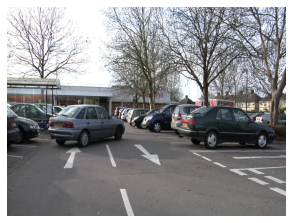

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

**open_image function**


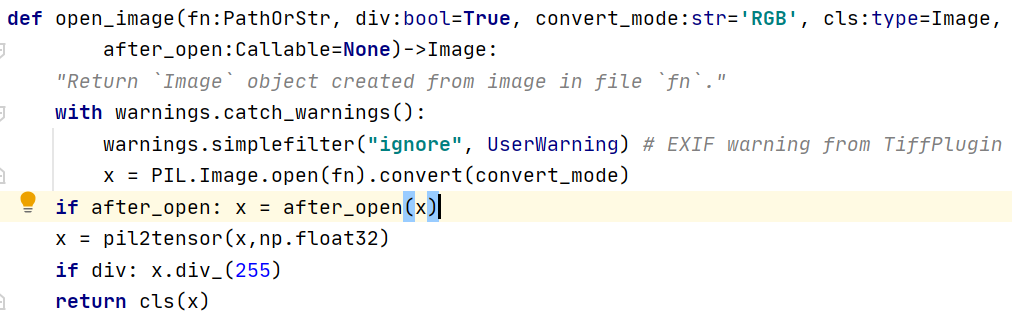

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
#x.stem: 파일명, x.suffix: 확장자명

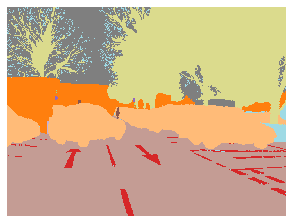

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

**open_mask function**

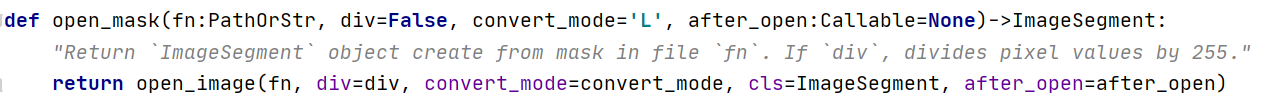

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

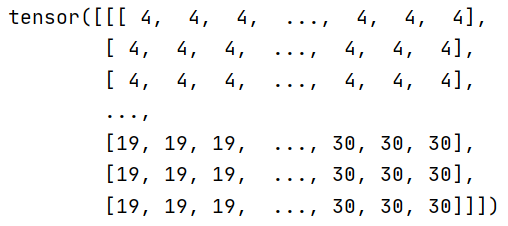

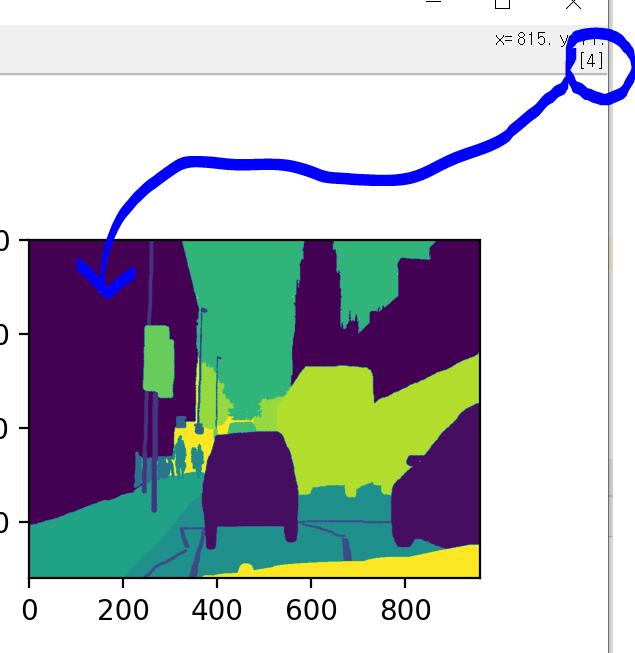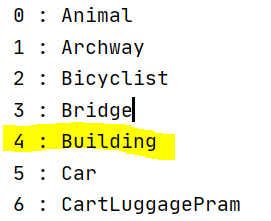

## Datasets

In [14]:
#아래 go big에서는 2로 나누지 않은 total data에 대한 학습을 진행함
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [42]:
src_size

array([720, 960])

In [43]:
size

array([720, 960])

In [15]:
src = (SegmentationItemList.from_folder(path_img) #create databunch from folder
       .split_by_fname_file('../valid.txt') #seperate training set and testing set. valid.text:list of original images
       .label_from_func(get_y_fn, classes=codes)) #find labelled image by function get_y_fn

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) #tfm_y=True, if we flip ori, we have to flip corresponding labbeld one too.
        .databunch(bs=bs)
        .normalize(imagenet_stats))

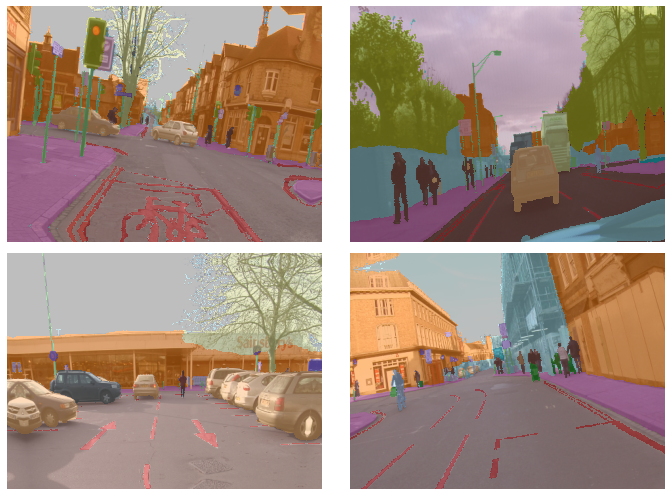

In [17]:
data.show_batch(2, figsize=(10,7))

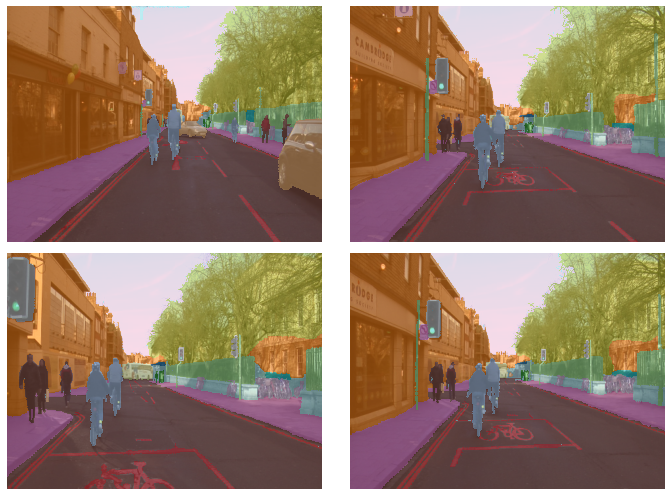

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
#void one's shouldn't be concluded for the calculation

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


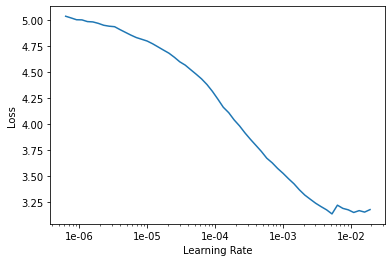

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=3e-3

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.326482,0.870035,0.797783,01:27
1,0.884034,0.679746,0.823676,01:25
2,0.720462,0.587333,0.848848,01:25
3,0.630327,0.588259,0.853776,01:24
4,0.688306,0.518850,0.873429,01:24
5,0.620141,0.529406,0.856820,01:24
6,0.558072,0.423724,0.879096,01:23
7,0.531938,0.459016,0.872528,01:23
8,0.486110,0.375019,0.901691,01:23
9,0.441354,0.332386,0.905176,01:23


In [26]:
learn.save('stage-1')

In [27]:
learn.load('stage-1');

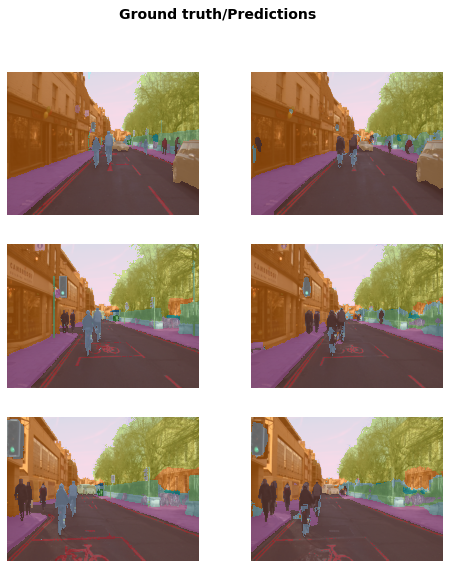

In [28]:
learn.show_results(rows=3, figsize=(8,9))
#ground truth: actual labbeled & Predictions

In [29]:
learn.unfreeze()

In [30]:
lrs = slice(lr/400,lr/4)

In [31]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.371577,0.309720,0.914834,01:27
1,0.363390,0.302307,0.917209,01:26
2,0.354871,0.301728,0.914918,01:27
3,0.342000,0.300022,0.917141,01:27
4,0.335569,0.306306,0.914450,01:27
5,0.321110,0.289425,0.919718,01:27
6,0.316721,0.281768,0.923403,01:27
7,0.307959,0.295064,0.914329,01:27
8,0.298046,0.299291,0.920435,01:27
9,0.296533,0.278868,0.925828,01:27


In [46]:
learn.save('stage-2');

this object has been destroyed


In [44]:
learn.load('stage-2');

this object has been destroyed


In [45]:
learn.show_results(rows=3, figsize=(8,9))

this object has been destroyed


**unfreezing and fine-tuning comparism**

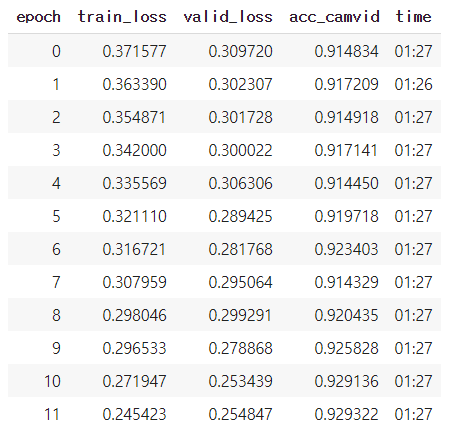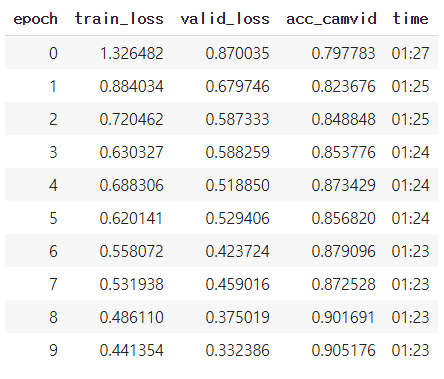

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

src_size 전체를 이용

In [33]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 14179MB of GPU RAM free


In [34]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [35]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

KeyboardInterrupt: ignored

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin